<h5>Project Pipeline</h5>
<li>Problem Definition : <strong>Diabetic Retinography</strong></li>
<li>Data Collection : <strong>Taken from Kaggle</strong></li>
<li>Data Annotation : <strong>Not Needed</strong></li>
<li>Data Processing : <strong>crop/resize/normalize, splitting in train/test</strong></li>
<li>Data Augmentation : <strong>rotate/flip/color</strong></li>
<li>Model Training : <strong>CNN</strong></li>
<li>Evalutaion : <strong>Accuracy, Precision, Recall, F1</strong></li>
<li>Saving Model : <strong>Normal</strong></li>
<li>API for Deployment : <strong>FastApi</strong></li>
<li>Testing</li>



In [ ]:
#importing all the required libraries
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
#setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [48]:
#building the data transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.48),(0.45))
])

In [49]:
#Loading the dataset and applying transformations
full_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)

#splitting dataset in train - test
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#dataloader
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
#implementing CNN 

class RetinographyNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(num_classes, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #128->64->32->16 due to pulling layer, 
        #128 filter from Conv2d
        self.classifier = nn.Sequential(
            nn.Flatten(),

            #input layer
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            #hidden layer
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            #hidden layer
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            #output layer
            nn.Linear(64,5)            
        )

        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [58]:
#training loop
model = RetinographyNN(3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

for epoch in range(epochs):
    model.train()

    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #forward pass
        outputs = model(images)

        #loss calc
        loss = criterion(outputs, labels)

        #grad clear
        optimizer.zero_grad()

        #backward pass
        loss.backward()

        #update grad
        optimizer.step()

        #loss tracking
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch : {epoch}, Loss : {avg_loss}")
    torch.cuda.empty_cache()

Epoch : 0, Loss : 1.4884189448573373
Epoch : 1, Loss : 1.350165922533382
Epoch : 2, Loss : 1.3087598464705728
Epoch : 3, Loss : 1.2748335640538822
Epoch : 4, Loss : 1.2427896681157025
Epoch : 5, Loss : 1.238926040855321
Epoch : 6, Loss : 1.233101805502718
Epoch : 7, Loss : 1.2110492424531416
Epoch : 8, Loss : 1.1809037002650173
Epoch : 9, Loss : 1.1917946176095442
Epoch : 10, Loss : 1.1677110940217972
Epoch : 11, Loss : 1.1512950618158688
Epoch : 12, Loss : 1.1559605679728768
Epoch : 13, Loss : 1.1726359860463575
Epoch : 14, Loss : 1.117669696157629
Epoch : 15, Loss : 1.1224834336475893
Epoch : 16, Loss : 1.1055650453675876
Epoch : 17, Loss : 1.1147377477450804
Epoch : 18, Loss : 1.1164014542644674
Epoch : 19, Loss : 1.0899028778076172
Epoch : 20, Loss : 1.0877990411086516
Epoch : 21, Loss : 1.082173858176578
Epoch : 22, Loss : 1.0616656081242994
Epoch : 23, Loss : 1.0729915093291889
Epoch : 24, Loss : 1.0502071556719867
Epoch : 25, Loss : 1.0389788814566352
Epoch : 26, Loss : 1.048696

In [59]:
#Evaluation
model.eval()

total = 0
correct = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total = total + labels.shape[0]
        correct = correct + (predicted == labels).sum().item()
    
    print(f"Accuracy : {correct/total}")


Accuracy : 0.6057046979865772


In [60]:
#classification report
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("Classification Report :-")
print(classification_report(y_true, y_pred))

Classification Report :-
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       175
           1       0.42      0.53      0.47        88
           2       0.53      0.68      0.59       192
           3       0.33      0.06      0.10        88
           4       0.39      0.25      0.30        53

    accuracy                           0.61       596
   macro avg       0.51      0.49      0.47       596
weighted avg       0.57      0.61      0.57       596



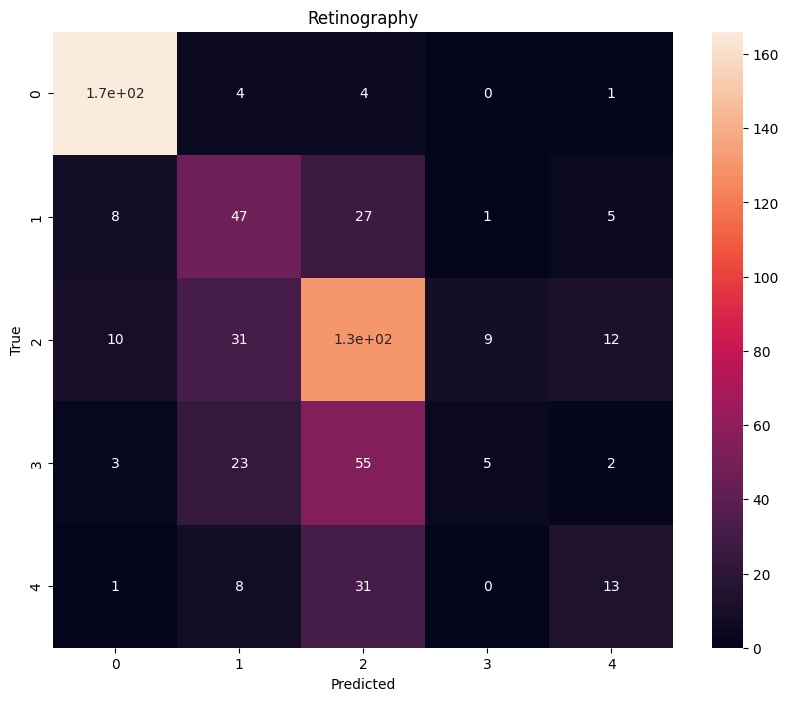

In [61]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Retinography")
plt.show()

In [ ]:
#saving the normal model
#torch.save(model.state_dict(), "normal_retinography_cnn_model.pth")